# Description

The project is simply doing the ex.9 page 365 and ex.12 page 366 from the book 'An Introduction to Statistical Learning with Applications in Python'.

# Ex 9

## Libraries

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
import numpy as np
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.tree import plot_tree, export_text
from sklearn.metrics import accuracy_score
import sklearn.model_selection as skm
import math
import pandas as pd
import matplotlib.pyplot as plt

### a)

In [2]:
OJ = load_data('OJ')
mapping = {'Yes': 1, 'No': 0}
OJ['Store7'] = OJ['Store7'].replace(mapping)
OJ

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.00,0,0,0.500000,1.99,1.75,0.24,0,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.30,0,1,0.600000,1.69,1.75,-0.06,0,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.00,0,0,0.680000,2.09,1.69,0.40,0,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.00,0,0,0.400000,1.69,1.69,0.00,0,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.00,0,0,0.956535,1.69,1.69,0.00,1,0.000000,0.000000,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,CH,252,7,1.86,2.09,0.10,0.00,0,0,0.587822,2.09,1.76,0.33,1,0.000000,0.053763,0.23,0
1066,CH,256,7,1.86,2.18,0.00,0.00,0,0,0.670258,2.18,1.86,0.32,1,0.000000,0.000000,0.32,0
1067,MM,257,7,1.86,2.18,0.00,0.00,0,0,0.736206,2.18,1.86,0.32,1,0.000000,0.000000,0.32,0
1068,CH,261,7,1.86,2.13,0.00,0.24,0,0,0.588965,1.89,1.86,0.03,1,0.112676,0.000000,0.27,0


In [3]:
model = MS(OJ.columns.drop('Purchase'), intercept=False)
D = model.fit_transform(OJ)
feature_names = list(D.columns)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
     OJ.loc[:, OJ.columns != "Purchase"], OJ["Purchase"], test_size=round(1-800/len(OJ),7), random_state=0)

In [5]:
len(X_train)

800

### b)

In [6]:
clf = DTC(criterion='entropy',
          max_depth=2,
          random_state=1)        
clf.fit(X_train, y_train)
accuracy_score(y_train, clf.predict(X_train))

0.8025

In [7]:
print("The training error is: " + str(round(1-accuracy_score(y_train, clf.predict(X_train)),5)))

The training error is: 0.1975


### c)

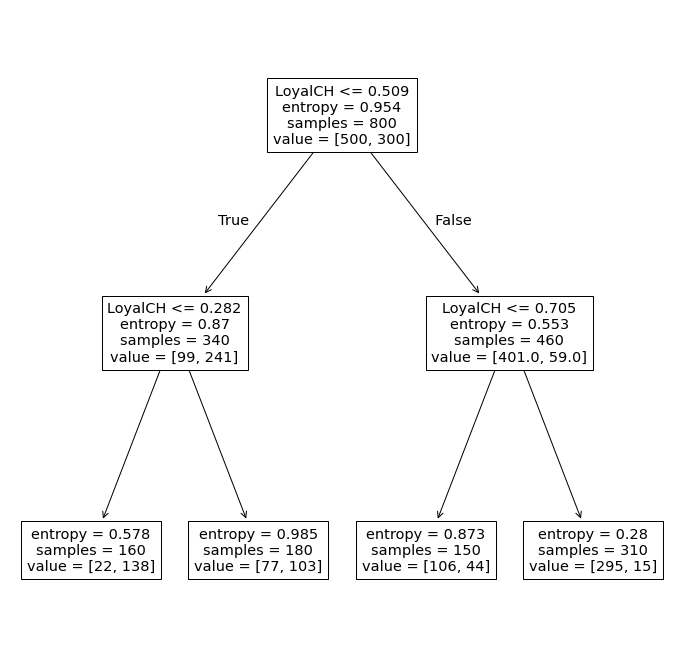

In [8]:
ax = plt.subplots(figsize=(12,12))[1]
plot_tree(clf,
          feature_names=feature_names,
          ax=ax);

In [9]:
print("Amount of terminal nodes: " + str(clf.tree_.n_leaves))

Amount of terminal nodes: 4


### d)

In [10]:
print(export_text(clf,
                  feature_names=feature_names,
                  show_weights=True))

|--- LoyalCH <= 0.51
|   |--- LoyalCH <= 0.28
|   |   |--- weights: [22.00, 138.00] class: MM
|   |--- LoyalCH >  0.28
|   |   |--- weights: [77.00, 103.00] class: MM
|--- LoyalCH >  0.51
|   |--- LoyalCH <= 0.71
|   |   |--- weights: [106.00, 44.00] class: CH
|   |--- LoyalCH >  0.71
|   |   |--- weights: [295.00, 15.00] class: CH



### e) 

In [11]:
confusion_table(clf.predict(X_test),y_test)

Truth,CH,MM
Predicted,,
CH,117,22
MM,36,95


In [12]:
print("Test error rate: " + str(1-accuracy_score(y_test, clf.predict(X_test))))

Test error rate: 0.2148148148148148


### f)

In [13]:
clf = DTC(criterion='entropy', random_state=0)
clf.fit(X_train, y_train)
ccp_path = clf.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(10,
                  random_state=1,
                  shuffle=True)

In [14]:
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, y_train)
print("Optimal tree height is " + str(round(math.log(grid.best_estimator_.tree_.n_leaves, 2))) + " with " + 
      str(grid.best_estimator_.tree_.n_leaves) + " leaves")

Optimal tree height is 3 with 7 leaves


### g)

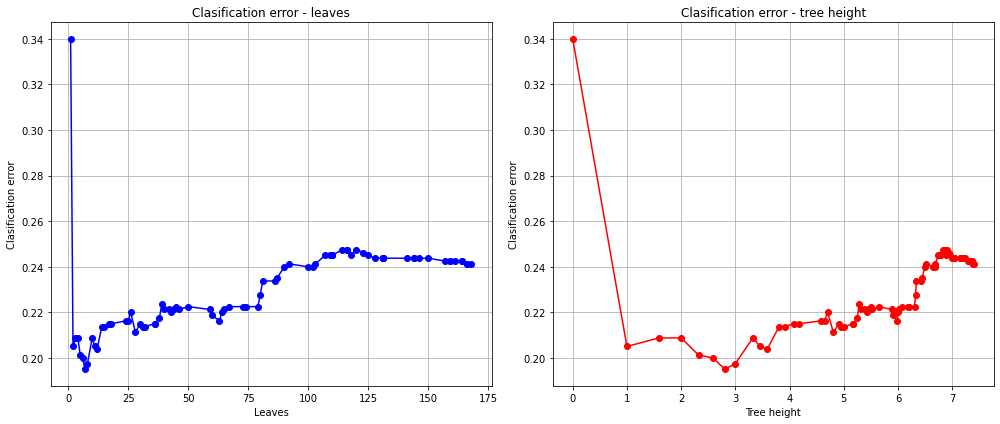

In [15]:
errors = []
leaf_amount= []
tree_height = []

for alpha in ccp_path.ccp_alphas:
    clf = DTC(criterion='entropy', random_state=0, ccp_alpha=alpha)
    cv_scores = skm.cross_val_score(clf, X_train, y_train, cv=kfold, scoring='accuracy')
    errors.append(1 - np.mean(cv_scores))  
    clf = DTC(criterion='entropy', random_state=0, ccp_alpha=alpha)
    clf.fit(X_train, y_train)
    leaf_amount.append(clf.tree_.n_leaves)
    tree_height.append(math.log2(clf.tree_.n_leaves))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(leaf_amount, errors, marker='o', color='b')
plt.xlabel('Leaves')
plt.ylabel('Clasification error')
plt.title('Clasification error - leaves')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(tree_height, errors, marker='o', color='r')
plt.xlabel('Tree height')
plt.ylabel('Clasification error')
plt.title('Clasification error - tree height')
plt.grid(True)

plt.tight_layout()
plt.show()

### h)

In [16]:
print("Tree size corresponding to the lowest cross-validated classifcation error: " + str(leaf_amount[np.argmin(errors)]))

Tree size corresponding to the lowest cross-validated classifcation error: 7


In [17]:
print("Tree height corresponding to the lowest cross-validated classifcation error: " + str(math.ceil(tree_height[np.argmin(errors)])))

Tree height corresponding to the lowest cross-validated classifcation error: 3


### i)

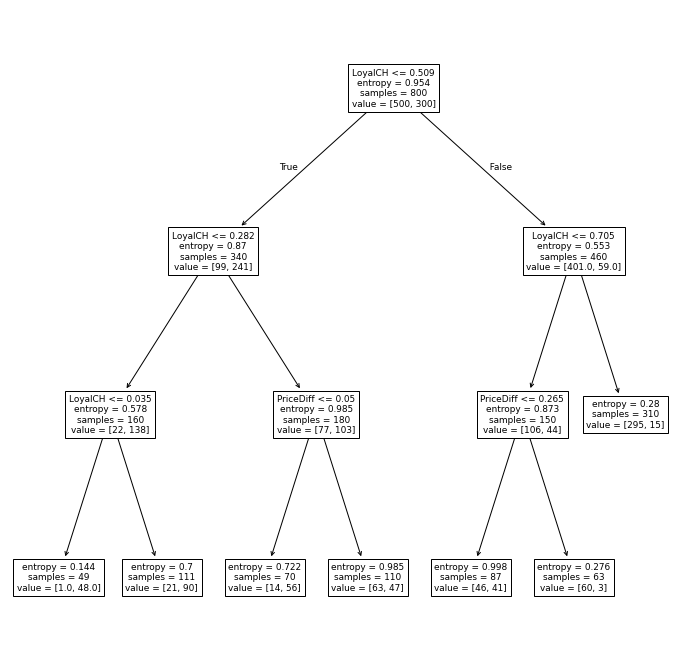

In [18]:
ax = plt.subplots(figsize=(12, 12))[1]
plot_tree(grid.best_estimator_,
          feature_names=feature_names,
          ax=ax);

### j)

In [19]:
print("The unpruned training error is: " + str(round(1-accuracy_score(y_train, clf.predict(X_train)),5)))
print("The pruned training error is: " + str(round(1-accuracy_score(y_train, grid.best_estimator_.predict(X_train)),5)))

The unpruned training error is: 0.375
The pruned training error is: 0.1775


### k)

In [20]:
print("The unpruned test error is: " + str(round(1-accuracy_score(y_test, clf.predict(X_test)),5)))
print("The pruned test error is: " + str(round(1-accuracy_score(y_test, grid.best_estimator_.predict(X_test)),5)))

The unpruned test error is: 0.43333
The pruned test error is: 0.18889


# Ex 12

## Libraries

In [21]:
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.ensemble import GradientBoostingRegressor as GBR
from ISLP.bart import BART
import statsmodels.api as sm
from ISLP.models import summarize
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

## Data preproccesing

Source of data: https://github.com/gchoi/Dataset/blob/master/oj.csv

In [22]:
OJ = pd.read_csv("oj.csv")
OJ = OJ.dropna()

model = MS(OJ.columns.drop('price'), intercept=False)
feature_names = list(model.fit_transform(OJ).columns)

mapping = {'tropicana': 1, 'minute.maid': 2, 'dominicks':3}
OJ['brand'] = OJ['brand'].replace(mapping)

X_train, X_test, y_train, y_test = train_test_split(
     OJ.loc[:, OJ.columns != "price"], OJ["price"], test_size=0.3, random_state=0)

OJ

,store,brand,week,logmove,feat,price,AGE60,EDUC,ETHNIC,INCOME,HHLARGE,WORKWOM,HVAL150,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5
0,2,1,40,9.018695,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
1,2,1,46,8.723231,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
2,2,1,47,8.253228,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
3,2,1,48,8.987197,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
4,2,1,50,9.093357,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28942,137,3,156,7.987524,0,2.00,0.209602,0.528362,0.11325,10.966490,0.092996,0.330293,0.860739,6.026484,0.705882,0.77253,0.333761
28943,137,3,157,8.502689,0,1.94,0.209602,0.528362,0.11325,10.966490,0.092996,0.330293,0.860739,6.026484,0.705882,0.77253,0.333761
28944,137,3,158,9.505991,0,1.59,0.209602,0.528362,0.11325,10.966490,0.092996,0.330293,0.860739,6.026484,0.705882,0.77253,0.333761
28945,137,3,159,10.927376,0,1.49,0.209602,0.528362,0.11325,10.966490,0.092996,0.330293,0.860739,6.026484,0.705882,0.77253,0.333761


### Converting the dataframes into arrays

In [23]:
X_train=X_train.to_numpy()
X_test=X_test.to_numpy()
y_train=y_train.to_numpy()
y_test=y_test.to_numpy()

### Custom function for estimating best parameters for each method

In [24]:
def est_params(grid, method):
    if method==1:
        g=GBR(random_state=0)
    elif method==2:
        g=BART(random_state=0)
    elif method==3: 
        g=RF(random_state=0)
    elif method==4:
        g=pipeline = Pipeline([('poly', PolynomialFeatures()), ('linear', LinearRegression())])
    grid_search = GridSearchCV(estimator=g, param_grid=grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    return print(grid_search.best_params_)

### List for results

In [25]:
results=dict()

## BOOSTING

In [26]:
est_params({'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3]}, 1)

{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500}


In [28]:
modelBOOST = GBR(n_estimators=500,learning_rate=0.1,max_depth=8,random_state=0)
modelBOOST.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=8, n_estimators=500, random_state=0)

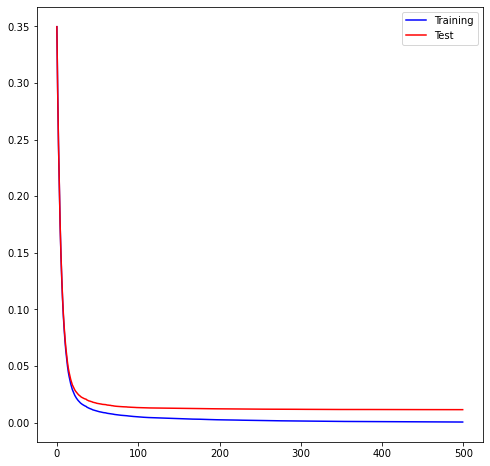

In [29]:
test_error = np.zeros_like(modelBOOST.train_score_)
for idx, y_ in enumerate(modelBOOST.staged_predict(X_test)):
    test_error[idx] = np.mean((y_test - y_)**2)
    
plot_idx = np.arange(modelBOOST.train_score_.shape[0])
ax = plt.subplots(figsize=(8,8))[1]
ax.plot(plot_idx,modelBOOST.train_score_,'b',label='Training')
ax.plot(plot_idx,test_error,'r',label='Test')
ax.legend()

In [30]:
feature_imp = pd.DataFrame({'importance':modelBOOST.feature_importances_},index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
brand,0.513344
week,0.213527
logmove,0.192814
SSTRDIST,0.017461
HVAL150,0.014460
feat,0.010336
INCOME,0.006884
EDUC,0.005761
AGE60,0.005338
CPDIST5,0.004340


In [31]:
print("MSE for Boosting = ", str(np.mean((y_test - modelBOOST.predict(X_test))**2)))
results["Boosting"] = round(np.mean((y_test - modelBOOST.predict(X_test))**2), 5)

MSE for Boosting =  0.011462441299407083


## BAGGING 

In [32]:
est_params({'n_estimators': [50, 100, 200, 300, 400, 500]}, 3)

{'n_estimators': 400}


In [33]:
modelBAGGING = RF(max_features=X_train.shape[1], n_estimators=400, random_state=0).fit(X_train, y_train)

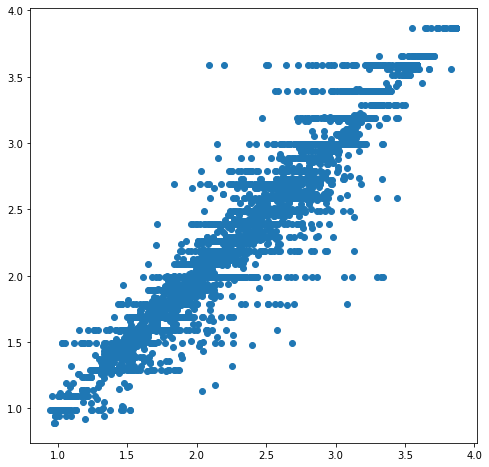

In [34]:
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(modelBAGGING.predict(X_test), y_test)

In [35]:
feature_imp = pd.DataFrame({'importance':modelBAGGING.feature_importances_},index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
brand,0.510208
week,0.203598
logmove,0.194351
SSTRDIST,0.019146
HVAL150,0.014571
feat,0.010661
AGE60,0.006901
INCOME,0.006751
EDUC,0.006156
CPDIST5,0.005991


In [36]:
print("MSE for Bagging = ", str(np.mean((y_test - modelBAGGING.predict(X_test))**2)))
results["Bagging"] = round(np.mean((y_test - modelBAGGING.predict(X_test))**2), 5)

MSE for Bagging =  0.017771124575633273


## RANDOM FOREST 

In [37]:
modelRANDOM_FOREST = RF(max_features=int(math.sqrt(X_train.shape[1]))+1, random_state=0).fit(X_train, y_train)

In [38]:
feature_imp = pd.DataFrame({'importance':modelRANDOM_FOREST.feature_importances_},index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
brand,0.475896
logmove,0.205650
week,0.189501
feat,0.031487
SSTRDIST,0.014870
HVAL150,0.012007
INCOME,0.010822
EDUC,0.008408
AGE60,0.008044
CPDIST5,0.007693


In [39]:
print("MSE for Random Forest = ", str(np.mean((y_test - modelRANDOM_FOREST.predict(X_test))**2)))
results["Random Forest"] = round(np.mean((y_test - modelRANDOM_FOREST.predict(X_test))**2), 5)

MSE for Random Forest =  0.03523300518710419


## BART

In [40]:
est_params({'burnin': [2,3,4,5,6,7],
    'ndraw': [2,5,7,10,12,15]}, 2)

{'burnin': 2, 'ndraw': 15}


In [41]:
modelBART = BART(random_state=0, burnin=2, ndraw=15)
modelBART.fit(X_train, y_train)

BART(burnin=2, ndraw=15, random_state=0)

In [42]:
var_inclusion = pd.DataFrame({"importance" : modelBART.variable_inclusion_.mean(0)/100},
index=model.fit_transform(OJ).columns)
var_inclusion.sort_values(by='importance', ascending=False)

,importance
logmove,0.380667
week,0.369333
brand,0.277333
feat,0.256667
HVAL150,0.184000
HHLARGE,0.174667
AGE60,0.174000
SSTRVOL,0.172667
store,0.167333
SSTRDIST,0.166667


In [43]:
print("MSE for BART = ", str(np.mean((y_test - modelBART.predict(X_test.astype(np.float32)))**2)))
results["BART"] = round(np.mean((y_test - modelBART.predict(X_test.astype(np.float32)))**2), 5)

MSE for BART =  0.0760569309393898


## Linear Regression

In [44]:
Linearmodel = sm.OLS(y_train, X_train)
fitted_model = Linearmodel.fit()
summarize(fitted_model)

,coef,std err,t,P>|t|
x1,-0.0002,0.000079,-2.133,0.033
x2,-0.5548,0.003000,-185.609,0.000
x3,-0.0031,0.000070,-43.450,0.000
x4,-0.2493,0.003000,-86.270,0.000
x5,-0.0197,0.007000,-2.883,0.004
x6,1.0260,0.080000,12.752,0.000
x7,-0.8184,0.058000,-14.168,0.000
x8,0.6664,0.019000,35.747,0.000
x9,0.5584,0.006000,87.940,0.000
x10,-1.1732,0.140000,-8.401,0.000


In [45]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.979
Model:                            OLS   Adj. R-squared (uncentered):              0.979
Method:                 Least Squares   F-statistic:                          5.841e+04
Date:                Tue, 02 Jul 2024   Prob (F-statistic):                        0.00
Time:                        00:18:58   Log-Likelihood:                         -7221.8
No. Observations:               20262   AIC:                                  1.448e+04
Df Residuals:                   20246   BIC:                                  1.460e+04
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0002   7.94e-05     -2.133      0.033      -0.000   -1.37e-05
x2            -0.5548      0.003   -185.609      0.000      -0.561      -0.549
x3            -0.0031   7.04e-05    -43.450      0.000      -0.003      -0.003
x4            -0.2493      0.003    -86.270      0.000      -0.255      -0.244
x5            -0.0197      0.007     -2.883      0.004      -0.033      -0.006
x6             1.0260      0.080     12.752      0.000       0.868       1.184
x7            -0.8184      0.058    -14.168      0.000      -0.932      -0.705
x8             0.6664      0.019     35.747      0.000       0.630       0.703
x9             0.5584      0.006     87.940      0.000       0.546       0.571
x10           -1.1732      0.140     -8.401      0.000      -1.447      -0.899
x11            0.2968      0.092      3.227      0.001       0.117       0.477
x12            0.2789      0.026     10.610      0.000       0.227       0.330
x13            0.0080      0.001      8.522      0.000       0.006       0.010
x14            0.0562      0.006      9.328      0.000       0.044       0.068
x15           -0.0480      0.004    -12.637      0.000      -0.055      -0.041
x16           -0.2156      0.016    -13.099      0.000      -0.248      -0.183
==============================================================================
Omnibus:                       63.357   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.902
Skew:                          -0.135   Prob(JB):                     1.33e-14
Kurtosis:                       3.053   Cond. No.                     9.28e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 9.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
print("MSE for LinearReg = ", str(np.mean((y_test - fitted_model.predict(X_test))**2)))
results["LinearReg"] = round(np.mean((y_test - fitted_model.predict(X_test))**2), 5)

MSE for LinearReg =  0.11621909567898134


## Logistic Regression

In [47]:
modele=[sm.GLM(y_train,X_train,family=sm.families.Poisson()).fit(), 
        sm.GLM(y_train,X_train,family=sm.families.Gaussian()).fit(),
        sm.GLM(y_train,X_train,family=sm.families.Gamma()).fit(),
        sm.GLM(y_train,X_train,family=sm.families.NegativeBinomial()).fit()]
b=[]
for element in modele:
    b.append(np.mean((y_test - element.predict(X_test))**2))

In [48]:
Logmodel = modele[np.argmin(b)]
summarize(Logmodel)

,coef,std err,z,P>|z|
x1,-0.000012,0.000014,-0.878,0.380
x2,0.109700,0.001000,194.924,0.000
x3,0.000500,0.000013,40.757,0.000
x4,0.057000,0.001000,103.878,0.000
x5,-0.003100,0.001000,-2.277,0.023
x6,-0.194100,0.014000,-13.704,0.000
x7,0.050000,0.010000,4.851,0.000
x8,-0.067000,0.003000,-21.255,0.000
x9,-0.027600,0.001000,-24.125,0.000
x10,0.114400,0.025000,4.572,0.000


In [49]:
Logmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                20262
Model:                            GLM   Df Residuals:                    20246
Model Family:                   Gamma   Df Model:                           15
Link Function:           InversePower   Scale:                        0.021029
Method:                          IRLS   Log-Likelihood:                -5863.3
Date:                Tue, 02 Jul 2024   Deviance:                       439.02
Time:                        00:19:17   Pearson chi2:                     426.
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9439
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -1.244e-05   1.42e-05     -0.878      0.380   -4.02e-05    1.53e-05
x2             0.1097      0.001    194.924      0.000       0.109       0.111
x3             0.0005   1.25e-05     40.757      0.000       0.000       0.001
x4             0.0570      0.001    103.878      0.000       0.056       0.058
x5            -0.0031      0.001     -2.277      0.023      -0.006      -0.000
x6            -0.1941      0.014    -13.704      0.000      -0.222      -0.166
x7             0.0500      0.010      4.851      0.000       0.030       0.070
x8            -0.0670      0.003    -21.255      0.000      -0.073      -0.061
x9            -0.0276      0.001    -24.125      0.000      -0.030      -0.025
x10            0.1144      0.025      4.572      0.000       0.065       0.163
x11           -0.0104      0.016     -0.636      0.525      -0.042       0.022
x12           -0.0771      0.005    -16.268      0.000      -0.086      -0.068
x13           -0.0006      0.000     -3.972      0.000      -0.001      -0.000
x14           -0.0034      0.001     -3.114      0.002      -0.005      -0.001
x15            0.0037      0.001      5.463      0.000       0.002       0.005
x16            0.0346      0.003     11.659      0.000       0.029       0.040
==============================================================================
"""

In [50]:
print("MSE for LogReg = ", str(np.mean((y_test - Logmodel.predict(X_test))**2)))
results["LogReg"] = round(np.mean((y_test - Logmodel.predict(X_test))**2), 5)

MSE for LogReg =  0.100586953385432


## Polynomial Regression

In [51]:
param_grid = {'poly__degree': np.arange(2, 5)}
est_params(param_grid, 4)

{'poly__degree': 4}


In [52]:
poly_model = PolynomialFeatures(degree=4)
poly_x_values = poly_model.fit_transform(X_train)
poly_model.fit(poly_x_values, y_train)
regression_model = LinearRegression()
regression_model.fit(poly_x_values, y_train)
poly_X_values = poly_model.fit_transform(X_test)
modelpoly=sm.OLS(y_train, sm.add_constant(X_train)).fit()
summarize(modelpoly)

,coef,std err,t,P>|t|
const,7.51810,0.203000,37.083,0.000
x1,0.00007,0.000077,0.909,0.363
x2,-0.55820,0.003000,-192.886,0.000
x3,-0.00310,0.000068,-45.719,0.000
x4,-0.26490,0.003000,-93.672,0.000
x5,0.00080,0.007000,0.119,0.905
x6,0.95280,0.078000,12.233,0.000
x7,0.18750,0.062000,3.018,0.003
x8,0.14620,0.023000,6.395,0.000
x9,-0.15970,0.020000,-7.860,0.000


In [53]:
modelpoly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     3486.
Date:                Tue, 02 Jul 2024   Prob (F-statistic):               0.00
Time:                        00:26:18   Log-Likelihood:                -6556.0
No. Observations:               20262   AIC:                         1.315e+04
Df Residuals:                   20245   BIC:                         1.328e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.5181      0.203     37.083      0.000       7.121       7.915
x1          7.004e-05   7.71e-05      0.909      0.363    -8.1e-05       0.000
x2            -0.5582      0.003   -192.886      0.000      -0.564      -0.553
x3            -0.0031   6.81e-05    -45.719      0.000      -0.003      -0.003
x4            -0.2649      0.003    -93.672      0.000      -0.270      -0.259
x5             0.0008      0.007      0.119      0.905      -0.012       0.014
x6             0.9528      0.078     12.233      0.000       0.800       1.105
x7             0.1875      0.062      3.018      0.003       0.066       0.309
x8             0.1462      0.023      6.395      0.000       0.101       0.191
x9            -0.1597      0.020     -7.860      0.000      -0.200      -0.120
x10            0.2923      0.141      2.076      0.038       0.016       0.568
x11           -0.1039      0.090     -1.159      0.247      -0.280       0.072
x12            0.3346      0.025     13.132      0.000       0.285       0.385
x13            0.0055      0.001      6.011      0.000       0.004       0.007
x14            0.0081      0.006      1.364      0.173      -0.004       0.020
x15           -0.0060      0.004     -1.565      0.118      -0.014       0.002
x16           -0.1206      0.016     -7.473      0.000      -0.152      -0.089
==============================================================================
Omnibus:                       78.628   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.468
Skew:                          -0.153   Prob(JB):                     5.54e-18
Kurtosis:                       3.011   Cond. No.                     1.22e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [54]:
print("MSE for PolyReg = ", str(np.mean((y_test - regression_model.predict(poly_X_values))**2)))
results["PolyReg"] = round(np.mean((y_test - regression_model.predict(poly_X_values))**2), 5)

MSE for PolyReg =  0.0607479374335625


## Results

In [55]:
results

{'Boosting': 0.01146,
 'Bagging': 0.01777,
 'Random Forest': 0.03523,
 'BART': 0.07606,
 'LinearReg': 0.11622,
 'LogReg': 0.10059,
 'PolyReg': 0.06075}

In [56]:
print("The smallest MSE value is",  results[min(results, key=results.get)],  
      "from the method called", min(results, key=results.get))

The smallest MSE value is 0.01146 from the method called Boosting


In [57]:
tree_mse = [results[method] for method in ['Boosting', 'Bagging', 'Random Forest', 'BART']]
regression_mse = [results[method] for method in ['LinearReg', 'LogReg', 'PolyReg']]

print("Mean of MSE values for tree methods:", round(sum(tree_mse) / len(tree_mse), 4))
print("Mean of MSE values for non-tree methods:", round(sum(regression_mse) / len(regression_mse), 4))

Mean of MSE values for tree methods: 0.0351
Mean of MSE values for non-tree methods: 0.0925
